## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

<a id='probability'></a>
#### Part I - Probability

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#read in dataset
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
#Number of uniquie users
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
#The proportion of users converted
df.query('converted == "1"')['converted'].sum()/df['converted'].shape[0]

0.11965919355605512

In [6]:
#The number of times the new_page and treatment don't line up
df.query('landing_page == "new_page"').query('group == "control"').shape[0] + df.query('landing_page == "old_page"').query('group == "treatment"').shape[0]

3893

Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('landing_page == "old_page"').query('group == "control"')
df2 = df2.append(df.query('landing_page == "new_page"').query('group == "treatment"'))


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()]



,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop([1899], inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].sum()/ df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_converted = df2.query('group == "control"')['converted']

control_prob = control_converted.sum()/ control_converted.shape[0]

control_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_converted = df2.query('group == "treatment"')['converted']

treatment_prob = treatment_converted.sum()/ treatment_converted.shape[0]

treatment_prob

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0] / df2['landing_page'].shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

>So far it does not look like either page leads to more conversions. The control group has a higher percentage of people that have converted but it is so small it is probably not significant. The control group and treatment group being the same size also eliminates the possibility of Simpsons paradox.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

>Null Hypothesis :        **$p_{new}$** - **$p_{old}$** <= 0

>Alternative Hypothesis : **$p_{new}$** - **$p_{old}$** > 0


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].sum()/ df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].sum()/ df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group =="treatment"')['converted'].count()
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group =="control"')['converted'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_pages_converted = np.random.choice([0,1], size =n_new, p=[(1-.119), .119])
new_pages_converted.shape[0],new_pages_converted.sum()

(145310, 17321)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_pages_converted = np.random.choice([0,1], size =n_old, p=[(1-.119), .119])
old_pages_converted.shape[0],old_pages_converted.sum()

(145274, 17159)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_new = new_pages_converted.sum()/new_pages_converted.shape[0]
p_old = old_pages_converted.sum()/old_pages_converted.shape[0]

p_new - p_old


0.0010855954135508272

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs =[]

p_new = df2['converted'].sum()/ df2.shape[0]
p_old = df2['converted'].sum()/ df2.shape[0]

new_converted_simulation = np.random.binomial(n_new, p_new,size =  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,size =  10000)/n_old

p_diffs = new_converted_simulation - old_converted_simulation

In [26]:
p_diffs.mean()

-1.251208099904105e-05

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

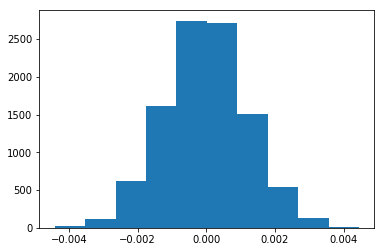

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
p_diffs = np.array(p_diffs)
og_diffs = treatment_prob - control_prob

((p_diffs < og_diffs).sum() / p_diffs.shape[0])

0.0964

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>I created a random distribution that resembles the null hypothesis which is that there is no advantage of using the new site compared to the old one. Then I compared this null hypothesis to our actual data and came up with a P value of .9. This actually means that 90% of the time, the control was more effective than the treatment. The P value is way above the .05 that we wanted for significance so we would fail to reject the null hypthesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group =="control"')['converted'].count()
n_new = df2.query('group =="treatment"')['converted'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score , p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old,n_new],alternative ='smaller')

z_score , p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z score signifies that our data is 1.3 standard deviations from the null hypothesis. After setting the alternative to 'smaller', the p values match as well.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We will be using a logistic regression since conversion is nominal.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1

df2[['control','ab_page']]= pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:53:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

This P value is assuming a 2 sided test instead of a 1 sided since we only want to know if the treatment will have a positive effect on converting.

If we look at the p value of .9 in our 1 sided test, changing the alternative hypothesis to the other direction would result in us having a p value of .1. Then changing from 1 sided to 2 sided will double the p value giving us approximately .19.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It would be a good idea to consider other factors because it does not seem like the treatment page is affecting the conversion rate. Looking into more variables might give us a better understanding of what really affects conversion rates. The disadvantages are that we might be introducing variables that are correlated to each other which would produce results that are not too accurate.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns

In [34]:
countries = pd.read_csv('countries.csv')

df3 = df2.join(countries.set_index('user_id'),on='user_id');
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,US
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,US


In [35]:
df3['intercept'] = 1

df3[['control','ab_page']]= pd.get_dummies(df3['group'])
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])

lm = sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK']])
results = lm.fit()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        22:53:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

>After adding country variables it still does not seem like there is a strong relationship between the variables and the conversion rate. The P values of CA and UK are way above the .05 error rate so we would fail to reject the null hypothesis.

In [37]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0